#future 30 days
#7 days past


# The dataset is sasional  and  Additive time series


A time series is a succession of chronologically ordered data spaced at equal or unequal intervals. The forecasting process consists of predicting the future value of a time series, either by modeling the series solely based on its past behavior (autoregressive) or by using other external variables.



https://medium.com/aiskunks/time-series-forecasting-using-deep-learning-ebe383913c5f

# Recurrent Neural Network for Daily Bike-Sharing Trip Prediction

This notebook explores the potential of Recurrent Neural Networks (RNNs) for daily bike-sharing trip prediction. 

### This notebook will focus on the following aspects:

* Data Acquisition: Explore and load a bike-sharing trip dataset and save on Hadoop filesystem.  
* Data Preprocessing: Clean and transform the data throught pyspark for RNN analysis. 
* Model Selection and Training: Develop and train LSTM and GRU models using TensorFlow.
* Model Evaluation: Evaluate the performance of the trained models. 
* Conclusion: Analyze the findings and potential benefits for bike-sharing companies.

### Import necessary libraries 


In [356]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, window, sum, lit, to_date
import matplotlib.pyplot as plt
import pyspark.sql.functions as psf
import pandas as pd
import seaborn as sns
import numpy as np
import keras
import math
import tensorflow as tf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, window, sum, lit
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import pyspark.sql.functions as psf
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose



import warnings
warnings.filterwarnings("ignore") 



### Apache Hadoop and PySpark for Scalable Processing
    
    Bike-sharing data can be vast. Traditional computing platforms might struggle to handle such large datasets efficiently. This is where Apache Hadoop and PySpark come into play.
    
### Apache Hadoop: 
    An open-source framework that facilitates distributed processing of large datasets across clusters of computers.
    
### Apache Spark: 
    Apache Spark™ is a multi-language engine for executing data engineering, data science, and machine learning on single-node machines or clusters. PySpark is a Python-like API for data processing tasks.


In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName("CA01_Sem_02").config("spark.executor.memory","10g").getOrCreate()
spark

24/03/22 15:06:36 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### Data_Ingestion Module
    To leverage the use of hadoop,  this module was created to read the csv files into a pyspark dataframe and save on hadoop hdfs system
    This function will be used once, its a programaticaly way to ingest data on hadoop filesystem.

In [3]:

# data_ingestion function: Loads all CSV files in a directory using PySpark and saves them to a specified output path on HDFS.
# Args: 
    # path: Path to the directory containing CSV files  
    # hd_path: Hadoop path on HDFS to save the processed files

def data_ingestion( path, hd_path):
    
    try:
        # Read all files in the directory matching the CSV extension (*.csv)
        df = spark.read.csv(path, header=True, inferSchema = True)

        # Save the DataFrame to Hadoop server - HDFS
        df.write.mode("overwrite").csv(hd_path, header=True)
        print('Data Ingestion Completed')

    except Exception as e:
        print("An error occurred:", e)
    
    
    

### Running the data_ingestion function
    In this process, all csv files will be loaded into a spark dataframe and saved on Hadoop using the function data_ingestion created.

In [14]:

# path to directory where the files are
path = "file:///home/hduser/Documents/CA01_Sem_02_MSc_Data_Analytics/*.csv"

# path where the files should be saved on hadoop
hd_path = "/user/hduser/bike_data/"

# Call the processing function
data_ingestion(path, hd_path)


Data Ingestion Completed


### Verifying the data on hadoop
    As the data is saved on local server, its possible to run the hdfs shell to verify if the data was savedd properly 

In [5]:
!hdfs dfs -ls /user/hduser/bike_data


Found 11 items
-rw-r--r--   1 hduser supergroup          0 2024-03-22 01:43 /user/hduser/bike_data/_SUCCESS
-rw-r--r--   1 hduser supergroup   96739828 2024-03-22 01:43 /user/hduser/bike_data/part-00000-454d576a-1573-4842-95b4-4f7556e392f8-c000.csv
-rw-r--r--   1 hduser supergroup   93859490 2024-03-22 01:43 /user/hduser/bike_data/part-00001-454d576a-1573-4842-95b4-4f7556e392f8-c000.csv
-rw-r--r--   1 hduser supergroup   93287714 2024-03-22 01:43 /user/hduser/bike_data/part-00002-454d576a-1573-4842-95b4-4f7556e392f8-c000.csv
-rw-r--r--   1 hduser supergroup   89508134 2024-03-22 01:43 /user/hduser/bike_data/part-00003-454d576a-1573-4842-95b4-4f7556e392f8-c000.csv
-rw-r--r--   1 hduser supergroup   86649859 2024-03-22 01:43 /user/hduser/bike_data/part-00004-454d576a-1573-4842-95b4-4f7556e392f8-c000.csv
-rw-r--r--   1 hduser supergroup   86128007 2024-03-22 01:43 /user/hduser/bike_data/part-00005-454d576a-1573-4842-95b4-4f7556e392f8-c000.csv
-rw-r--r--   1 hduser supergroup   78088682 20

### Load data from hadoop

    From now, all data will be loaded from Hadoop

In [41]:

hd_path = "/user/hduser/bike_data/"

try:
   

  # Read the CSV files using the specified path
  df = spark.read.csv(hd_path, header = True, inferSchema = True)

  # Print the first few rows of the DataFrame (optional)
  df.show(2)

   
except Exception as e:
    print("An error occurred:", str(e))


+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+---------+----------+-----------------+------------------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|start_lat| start_lng|          end_lat|           end_lng|member_casual|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+---------+----------+-----------------+------------------+-------------+
|20CAF4CAD9186B1C|  docked_bike|2023-03-26 16:52:35|2023-03-26 17:22:08|Washington & Inde...|           31272|15th St & Constit...|         31321|38.886978|-77.013769|        38.892244|        -77.033234|       casual|
|695D9110D59A0A42| classic_bike|2023-03-28 16:51:30|2023-03-28 17:06:32|      11th & C St SE|           31659|D St & Marylan

The df.printSchema() function in Apache Spark is used for inspecting the schema of a DataFrame. 
The schema essentially defines the structure of your data, specifying the names and data types of each column in the DataFrame.

**Column Name:** The name assigned to each column in the DataFrame.

**Data Type:** The specific data type of each column, such as int, string, double, etc. This indicates how the data in that column is stored and interpreted.

**Nullability:** Whether a column allows null values or not. It will be displayed as true if null values are allowed, and false if not.

In [42]:
df.printSchema()

root
 |-- ride_id: string (nullable = true)
 |-- rideable_type: string (nullable = true)
 |-- started_at: timestamp (nullable = true)
 |-- ended_at: timestamp (nullable = true)
 |-- start_station_name: string (nullable = true)
 |-- start_station_id: integer (nullable = true)
 |-- end_station_name: string (nullable = true)
 |-- end_station_id: integer (nullable = true)
 |-- start_lat: double (nullable = true)
 |-- start_lng: double (nullable = true)
 |-- end_lat: double (nullable = true)
 |-- end_lng: double (nullable = true)
 |-- member_casual: string (nullable = true)



### Checking the "shape" of the dataframe


In [43]:
print((df.count(), len(df.columns)))

(4467334, 13)


### Data Engineering 
When it comes to using RNNs for time series forecasting or analysis, the data structure must have some level of consistency, as each row of the dataset represents one trip, A new column will be created to represent the tripa and only date and trips were selected from the dataset

In [44]:
trips = df.select("started_at")

In [45]:
trips.show(5)

+-------------------+
|         started_at|
+-------------------+
|2023-03-26 16:52:35|
|2023-03-28 16:51:30|
|2023-03-28 19:25:55|
|2023-03-03 16:33:58|
|2023-03-11 14:31:24|
+-------------------+
only showing top 5 rows



In [46]:
trips = trips.withColumn("started_at",to_date(col("started_at")).alias("date"))

In [47]:
trips.show(5)

+----------+
|started_at|
+----------+
|2023-03-26|
|2023-03-28|
|2023-03-28|
|2023-03-03|
|2023-03-11|
+----------+
only showing top 5 rows



In [48]:
trips = trips.withColumn("trips", lit(1))

In [49]:
trips.show(5)

+----------+-----+
|started_at|trips|
+----------+-----+
|2023-03-26|    1|
|2023-03-28|    1|
|2023-03-28|    1|
|2023-03-03|    1|
|2023-03-11|    1|
+----------+-----+
only showing top 5 rows



In [50]:
trips.printSchema()

root
 |-- started_at: date (nullable = true)
 |-- trips: integer (nullable = false)



# Grouping by date
to create a consistent dataset,  all trips will be grouped by date, and summ all trips for each day.

In [54]:
#window_spec = window(trips['started_at'], "1 day")
daily_df = trips.groupBy("started_at").agg(sum("trips").alias("total_trips"))


In [56]:
daily_df = daily_df.orderBy("started_at")

In [57]:
daily_df.show(10)

+----------+-----------+
|started_at|total_trips|
+----------+-----------+
|2023-01-01|       6787|
|2023-01-02|       7240|
|2023-01-03|       7559|
|2023-01-04|       7791|
|2023-01-05|       8409|
|2023-01-06|       6719|
|2023-01-07|       7122|
|2023-01-08|       5176|
|2023-01-09|       6520|
|2023-01-10|       7303|
+----------+-----------+
only showing top 10 rows



In [58]:
daily_df.describe().show()

+-------+------------------+
|summary|       total_trips|
+-------+------------------+
|  count|               365|
|   mean|12239.271232876712|
| stddev| 3983.046929307485|
|    min|              2369|
|    max|             20174|
+-------+------------------+



### Insigh from describe method

**Data Size:** 
    The count value (365) indicates that the data is for 365 days, which means a full year of daily bike trips.
**Central Tendency:** 
    The mean value (12239.27) is the average number of daily bike trips across the year. 
**Variability:**
    The stddev value (3983.05) this high standard deviation relative to the mean suggests significant variability in the number of trips per day. There could be days with much higher or lower trips compared to the average.
**Range:**
    The min value (2369) and max value (20174) shows the spread of the data, and there are days with low rides, and day with very high rides (10 times) the lower day.


In [225]:
# Converting PySpark DataFrame to Pandas DataFrame
#pandas_df = daily_df.toPandas()

# Saving transformed data in csv format for future usage
pandas_df.to_csv("pandas_df.csv", index = False, header = True)

### EDA - Understanding the Data

In [436]:
pandas_df = pd.read_csv("pandas_df.csv")

In [437]:
pandas_df.head()

,started_at,total_trips
0,2023-01-01,6787
1,2023-01-02,7240
2,2023-01-03,7559
3,2023-01-04,7791
4,2023-01-05,8409


### Distribution and Skewness

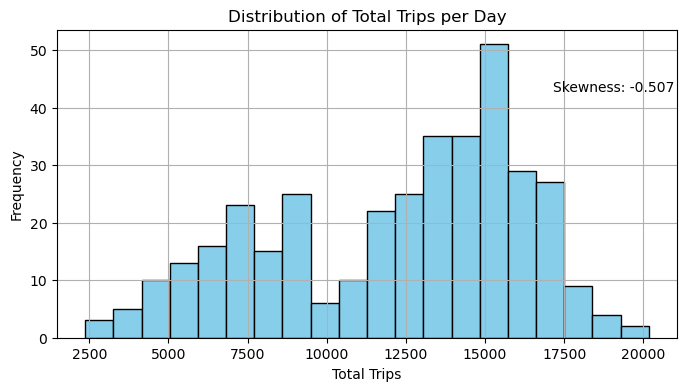

In [438]:

# Calculate skewness
skewness = pd.Series(pandas_df['total_trips']).skew()

# Plot the histogram
plt.figure(figsize=(8,4))
plt.hist(pandas_df['total_trips'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Trips per Day')
plt.xlabel('Total Trips')
plt.ylabel('Frequency')
plt.grid(True)

# Add skewness as annotation
plt.annotate(f"Skewness: {skewness:.3f}", xy=(0.8, 0.8), xycoords='axes fraction', fontsize=10)
plt.show()



### Insight from the Distribution Plot

Most days have between 7500 and 15000 total trips. There are also a fewer number of days that have either a very low or very high number of total trips.

**Shape of the Distribution:** 

    The distribution appears to be symmetrical, but there might be a slight tail towards the higher number of trips, also the number of daily bike trips varies, but most days fall within a certain range. 

**Skewness:**

    A value of 0 indicates a symmetrical distribution, while positive values indicate a skew to the right and negative values indicate a skew to the left.
    This negative skewness (-0.5073) suggests that the distribution has a longer tail towards lower daily trip counts compared to the average (mean). 

### Boxplot and Scatter Plot - Ouliers

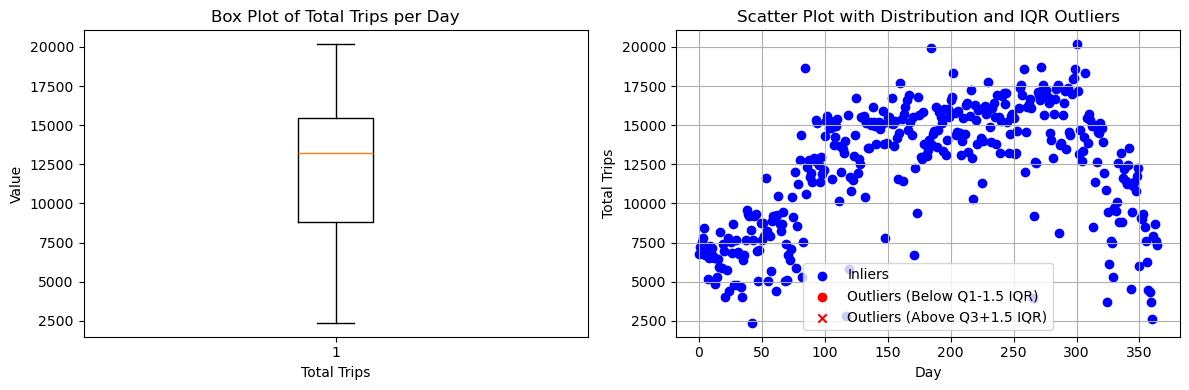

In [439]:

# Calculate quartiles and IQR
Q1 = pandas_df['total_trips'].quantile(0.25)
Q3 = pandas_df['total_trips'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds based on 1.5 IQR
lower_threshold = Q1 - 1.5 * IQR
upper_threshold = Q3 + 1.5 * IQR

# Create the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4)) 

# Creating a boxplot in the first subplot
ax1.boxplot(pandas_df['total_trips'])
ax1.set_title('Box Plot of Total Trips per Day')
ax1.set_xlabel('Total Trips')
ax1.set_ylabel('Value')
ax1.grid(False)

# creating a scatter plot with IQR outliers in the second subplot
ax2.scatter(pandas_df.index, pandas_df['total_trips'], color='blue', label='Inliers')
ax2.scatter(pandas_df[pandas_df['total_trips'] < lower_threshold].index, 
            pandas_df[pandas_df['total_trips'] < lower_threshold]['total_trips'], 
            color='red', marker='o', label='Outliers (Below Q1-1.5 IQR)')
ax2.scatter(pandas_df[pandas_df['total_trips'] > upper_threshold].index, 
            pandas_df[pandas_df['total_trips'] > upper_threshold]['total_trips'], 
            color='red', marker='x', label='Outliers (Above Q3+1.5 IQR)')

ax2.set_title('Scatter Plot with Distribution and IQR Outliers')
ax2.set_xlabel('Day') 
ax2.set_ylabel('Total Trips')
ax2.grid(True)
ax2.legend()

plt.tight_layout()

plt.show()


### Insight from BoxPlot
As already shown on distribution plot, the box extends from roughly 7,500 to 12,500 trips, indicating that there is variability in the number of daily trips, but most days fall within this range.

### From Scatter plot 
**Overall Distribution:** Most of the data points cluster around the center, what means the data is mostly in a range.

**Outliers:** Although, there are some points close to the IRQ threshold, there arent outliers.
    
    

# Analisys of Trips Per Month

In [440]:
def transform_dataframe(window, df):
    if window == 'weekly':
        df['started_at'] = pd.to_datetime(df['started_at'])
        df['weekday']=df['started_at'].dt.weekday
        df = df.groupby("weekday")["total_trips"].sum().reset_index()

        df = df.sort_values(by="weekday")
        df['weekday']=df['weekday'].map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})
    else:
        df['started_at'] = pd.to_datetime(df['started_at'])
        df['month']=df['started_at'].dt.month
        df = df.sort_values(by="month")
        df = df.groupby("month")["total_trips"].sum().reset_index()
        df['month']=df['month'].map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'})
       
    return df
    


In [441]:
df = pandas_df
weekly = transform_dataframe('weekly',df)
monthly = transform_dataframe('montlhy',df)

weekly

,weekday,total_trips
0,Mon,583199
1,Tue,651357
2,Wed,668960
3,Thu,676086
4,Fri,623918
5,Sat,664971
6,Sun,598843


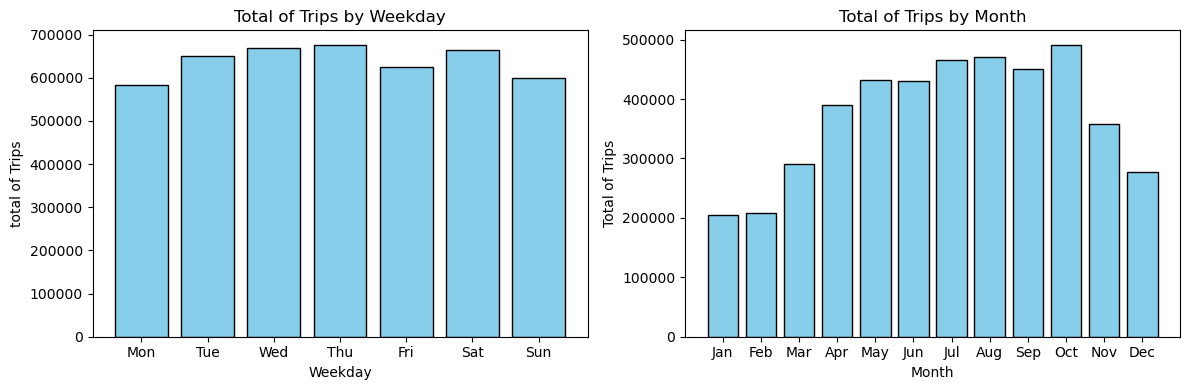

In [442]:
weekly = transform_dataframe('weekly',pandas_df)
monthly = transform_dataframe('montly',pandas_df)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4)) 

ax1.bar(weekly["weekday"], weekly["total_trips"], color='skyblue', edgecolor='black')
ax1.set_xlabel('Weekday')
ax1.set_ylabel('total of Trips')
ax1.set_title('Total of Trips by Weekday')

ax2.bar(monthly["month"], monthly["total_trips"], color='skyblue', edgecolor='black')
ax2.set_xlabel('Month')
ax2.set_ylabel('Total of Trips')
ax2.set_title('Total of Trips by Month')

fig.tight_layout()

fig.show()





### Insight from thiese plots:

From the weekly plot, its possible to observe higher trips on weekdays (Monday to Friday) compared to weekends (Saturday and Sunday). This suggests that bike-sharing is likely used for commuting purposes during weekdays.
From the Monthly plot, its possible to observe that in the Winter (Winter in Washington DC lasts from the beginning of December to March 1st and is known to be very cold and snowy), there are fewer trips.

# Trips by day

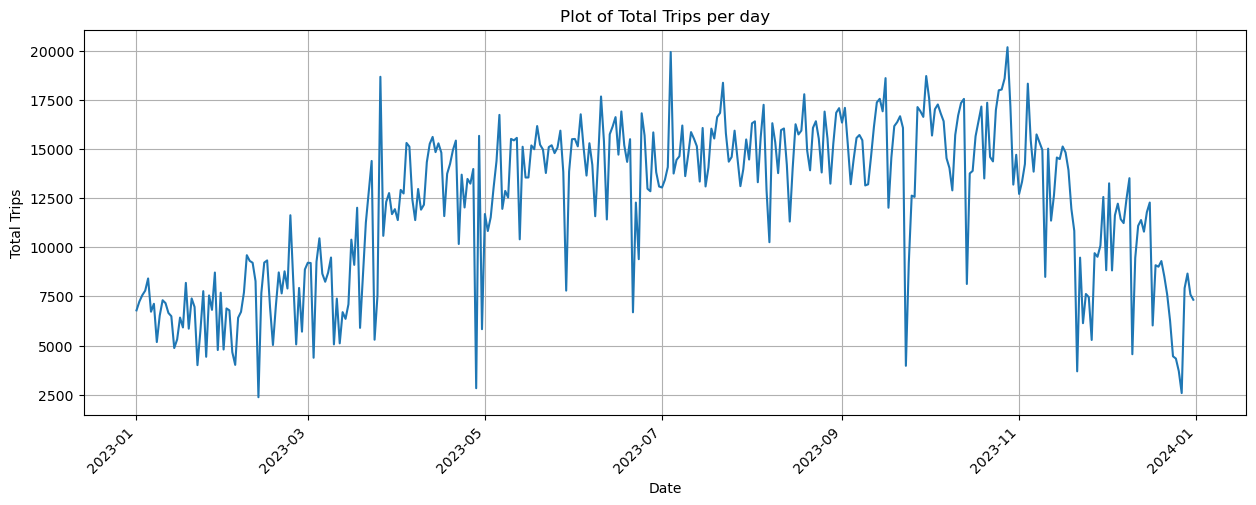

In [443]:

pandas_df['started_at'] = pd.to_datetime(pandas_df['started_at'])

plt.figure(figsize=(15, 5))

plt.plot(pandas_df["started_at"], pandas_df["total_trips"])

plt.xlabel("Date")
plt.ylabel("Total Trips")
plt.title("Plot of Total Trips per day")
plt.xticks(rotation=45, ha='right')
plt.grid(True) 
plt.show()


In [444]:
pandas_df = pandas_df[["started_at","total_trips"]]

In [445]:
# The dataset is sasional  and  Additive time series
pandas_df.set_index("started_at", inplace=True, verify_integrity=True)


In [446]:
pandas_df

,total_trips
started_at,
2023-01-01,6787
2023-01-02,7240
2023-01-03,7559
2023-01-04,7791
2023-01-05,8409
...,...
2023-12-27,2580
2023-12-28,7918
2023-12-29,8659


<Figure size 1500x500 with 0 Axes>

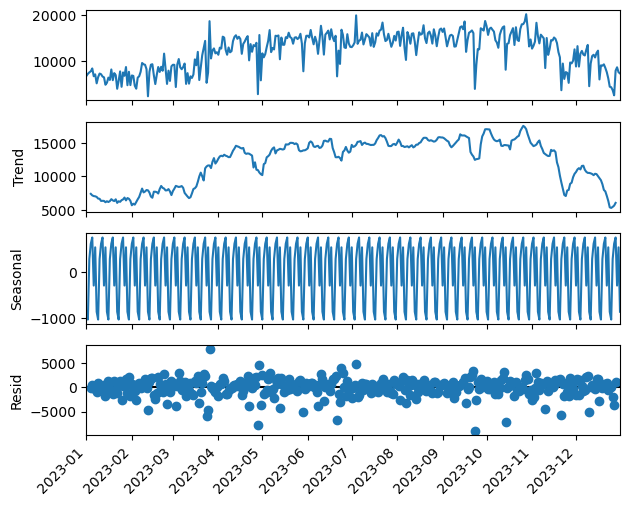

In [447]:
decomposition = seasonal_decompose(pandas_df, model='additive')

plt.figure(figsize=(15, 5))
# Analyze the seasonal component

# Plot the decomposed components
decomposition.plot()
plt.xticks(rotation=45, ha='right')

plt.show();

From this plot, the data has a seasonal component.



# LSTM Model Building:



    For building a LSTM model, its important to observe some parameters:
    Input layer: This layer takes the sequence of past trip counts as input. for this project, a window size of past 7 days was chosen to feed into the LSTM.
    LSTM layer: This layer is the core of the model, responsible for learning long-term dependencies in the trip count data. The model will be evaluated with different layers and numbers.
    Output layer: This layer predicts the future trip count. It will be used a single neuron with a linear activation for numerical prediction.
       
    TensorFlow is designed to work primarily with NumPy arrays. Because of this, pandas.core.series will be transform into NumPy arrays.



        The next thing we need to do is to specify our number of timesteps. Timesteps specify how many previous observations should be considered when the recurrent neural network makes a prediction about the current observation.
    We will use 7 (week based) timesteps. This means that for every day that the neural network predicts, it will consider the previous 7 days of trips to determine its output. 


In [448]:
trips = pandas_df.iloc[:,-1]

In [449]:
type(trips)

pandas.core.series.Series

In [450]:
def preprocessing(scaler, look_back):
        
    pandas_df = pd.read_csv("pandas_df.csv")
    trips = pandas_df.iloc[:,-1]
    
   
    # convert to numpy array
    np_trips = trips.to_numpy()
    np_trips = np_trips.astype('float32')
    np_trips = np_trips.reshape(-1,1)


    # convert an array of values into a dataset matrix
    def create_dataset(dataset, look_back):
    	dataX, dataY = [], []
    	for i in range(len(dataset)-look_back-1):
    		a = dataset[i:(i+look_back), 0]
    		dataX.append(a)
    		dataY.append(dataset[i + look_back, 0])
    	return np.array(dataX), np.array(dataY)

    # normalize the dataset
    np_trips = scaler.fit_transform(np_trips)
    
    # split into train and test sets
    train_size = int(len(np_trips) * 0.75)
    test_size = len(np_trips) - train_size
    train, test = np_trips[0:train_size,:], np_trips[train_size:len(np_trips),:]
    
  
   
    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


    
    
    trainX.shape, testX.shape
    return trainX, testX, trainY, testY, np_trips

In [451]:
look_back = 1  # defining the look_back


# Model 01

In [452]:

# create and fit the LSTM network
model1 = Sequential()
model1.add(LSTM(8, input_shape=(1, look_back)))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')
model1.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_41 (LSTM)                  │ (None, 8)              │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329 (1.29 KB)

 Trainable params: 329 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

In [453]:
# scaler to normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

#call the function processing
trainX, testX , trainY , testY, np_trips = preprocessing(scaler, look_back)


model1.fit(trainX, trainY, epochs=300, batch_size=16, verbose=1)

Epoch 1/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3622
Epoch 2/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3116 
Epoch 3/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2619 
Epoch 4/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2323 
Epoch 5/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1783 
Epoch 6/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1488 
Epoch 7/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1091 
Epoch 8/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0890 
Epoch 9/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0712 
Epoch 10/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0613 
Epoch 11/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0501 
Epoch 12/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0396 
Epoch 13/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0360 
Epoch 14/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0325 
Epoch 15/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss

In [454]:
# make predictions
trainPredict = model1.predict(trainX)
testPredict = model1.predict(testX)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [455]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [456]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 2680.46 RMSE
Test Score: 2700.08 RMSE


RMSE (Root Mean Squared Error):

    It measures the difference between predicted and actual trip counts.
    Lower RMSE indicates better performance. Ideally, you want the error to be as small as possible.

Training vs Test Score:

    The training score (0.13) is slightly lower than the test score (0.17), which is a good sign. It indicates that the model is not overfitting to the training data and can generalize somewhat well to unseen data (test set).

Interpretation:

    An RMSE of 0.13 on the training data suggests that on average, the model's predictions are off by about 0.13 times the scale of your trip count data.
    The test score of 0.17 indicates a slightly higher average error on unseen data, but it's still relatively low.

Considering the Data Size:

    With a limited dataset size of 365 days, achieving very low RMSE scores might be challenging. The model might not be able to capture all the complex variations in the daily trip counts.

Overall Assessment:

These scores suggest that the LSTM model is capturing some underlying patterns in the trip count data and can make reasonable predictions. However, there's still room for improvement.

In [457]:
#shift train predictions for plotting
trainPredictPlot = np.empty_like(np_trips)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict


# shift test predictions for plotting
testPredictPlot = np.empty_like(np_trips)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(np_trips)-1, :] = testPredict


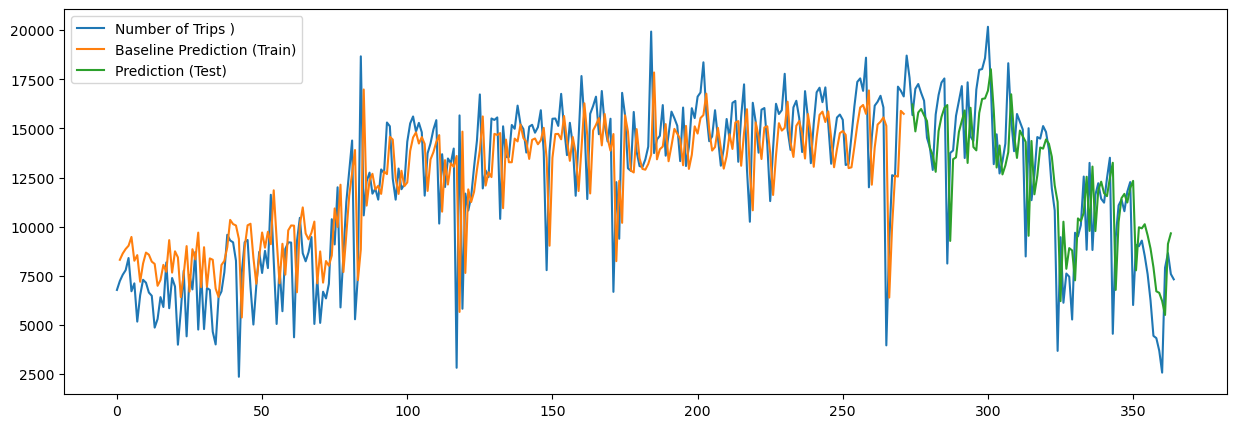

In [458]:
# plot baseline and predictions

plt.figure(figsize=(15, 5))
plt.plot(scaler.inverse_transform(np_trips))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Number of Trips )', 'Baseline Prediction (Train)', 'Prediction (Test)'], loc='upper left')
plt.show()

# MODEL 02   - LSTM Hyperparameter


In [459]:


from keras.regularizers import L2
model2 = Sequential()
model2.add(LSTM(128, return_sequences=True, input_shape=(1, look_back)))  # Look_back set to 365
model2.add(LSTM(units=64, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)))
#model2.add(Dropout(0.2))  # Uncomment and adjust dropout rate
model2.add(LSTM(32))
#model2.add(Dropout(0.2))
model2.add(Dense(16))  # Added a dense layer
model2.add(Dense(1, activation='relu'))
model2.compile(loss='MSLE', optimizer='RMSprop')
model2.summary()


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_42 (LSTM)                  │ (None, 1, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,929 (503.63 KB)

 Trainable params: 128,929 (503.63 KB)

 Non-trainable params: 0 (0.00 B)

In [460]:

# scaler to normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

#call the function processing
trainX, testX , trainY , testY, np_trips = preprocessing(scaler, look_back)

model2.fit(trainX, trainY, epochs=300, validation_data=(testX,testY), batch_size=16, verbose=1)

Epoch 1/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 1.5875 - val_loss: 1.0018
Epoch 2/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8881 - val_loss: 0.6063
Epoch 3/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5358 - val_loss: 0.3603
Epoch 4/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3127 - val_loss: 0.2004
Epoch 5/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1688 - val_loss: 0.1053
Epoch 6/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0877 - val_loss: 0.0559
Epoch 7/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0442 - val_loss: 0.0350
Epoch 8/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0279 - val_loss: 0.0281
Epoch 9/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0256 - val_loss: 0.0264
Epoch 10/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0217 - val_loss: 0.0265
Epoch 11/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0226 - val_loss: 0.0263
Epoch 12/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

In [461]:
# make predictions
trainPredict = model2.predict(trainX)
testPredict = model2.predict(testX)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [462]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


In [463]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 2842.49 RMSE
Test Score: 2809.97 RMSE


In [464]:
# shift train trainPredictPlot for plotting
trainPredictPlot = np.empty_like(np_trips)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict


# shift test testPredictPlot for plotting
testPredictPlot = np.empty_like(np_trips)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(np_trips)-1, :] = testPredict


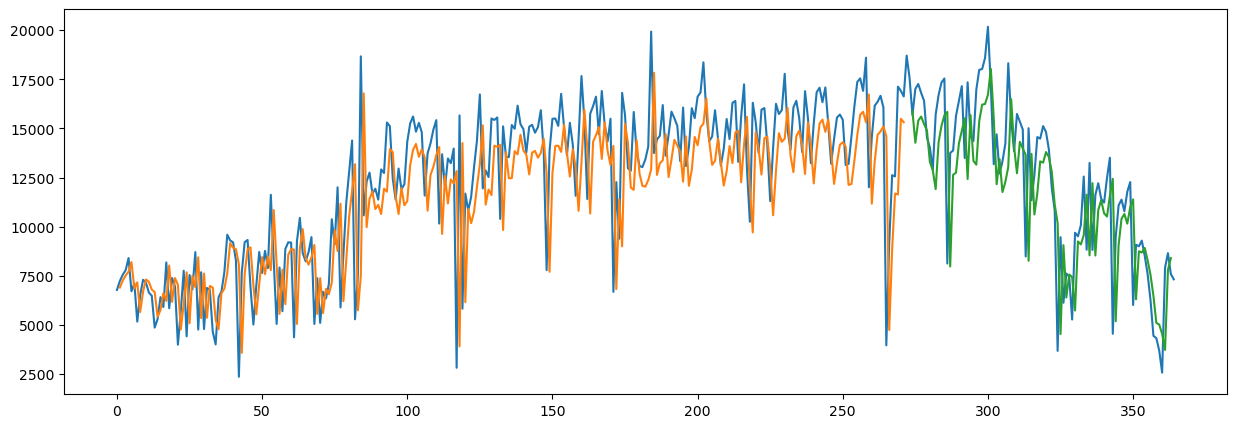

In [465]:
# plot baseline and predictions
plt.figure(figsize=(15, 5))

plt.plot(scaler.inverse_transform(np_trips))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Model 03 - GRU


In [466]:
# Define the GRU model
model3 = keras.Sequential()
model3.add(GRU(128, return_sequences=True, input_shape=(1, look_back)))  # Look_back set to 365
model3.add(GRU(units=64, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)))
model3.add(Dropout(0.2))  # Uncomment and adjust dropout rate
model3.add(GRU(32))
model3.add(Dropout(0.2))
model3.add(Dense(16))  # Added a dense layer
model3.add(Dense(1))
model3.compile(loss='mean_squared_logarithmic_error', optimizer='adam')
model3.summary()


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_12 (GRU)                    │ (None, 1, 128)         │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ (None, 1, 64)          │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_14 (GRU)                    │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,505 (380.88 KB)

 Trainable params: 97,505 (380.88 KB)

 Non-trainable params: 0 (0.00 B)

In [467]:
# scaler to normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

#call the function processing
trainX, testX , trainY , testY, np_trips = preprocessing(scaler, look_back)


model3.fit(trainX, trainY, epochs=300, validation_data=(testX,testY), batch_size=16, verbose=1)

Epoch 1/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 1.5441 - val_loss: 1.0645
Epoch 2/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9699 - val_loss: 0.7051
Epoch 3/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6361 - val_loss: 0.4593
Epoch 4/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4125 - val_loss: 0.2965
Epoch 5/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2647 - val_loss: 0.1901
Epoch 6/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1707 - val_loss: 0.1223
Epoch 7/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1089 - val_loss: 0.0796
Epoch 8/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0709 - val_loss: 0.0527
Epoch 9/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0482 - val_loss: 0.0365
Epoch 10/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0352 - val_loss: 0.0264
Epoch 11/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0234 - val_loss: 0.0204
Epoch 12/300
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

In [468]:

# make predictions
trainPredict = model2.predict(trainX)
testPredict = model2.predict(testX)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [469]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [470]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2842.49 RMSE
Test Score: 2809.97 RMSE


In [471]:
# shift train trainPredictPlot for plotting
trainPredictPlot = np.empty_like(np_trips)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict


# shift test testPredictPlot for plotting
testPredictPlot = np.empty_like(np_trips)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(np_trips)-1, :] = testPredict

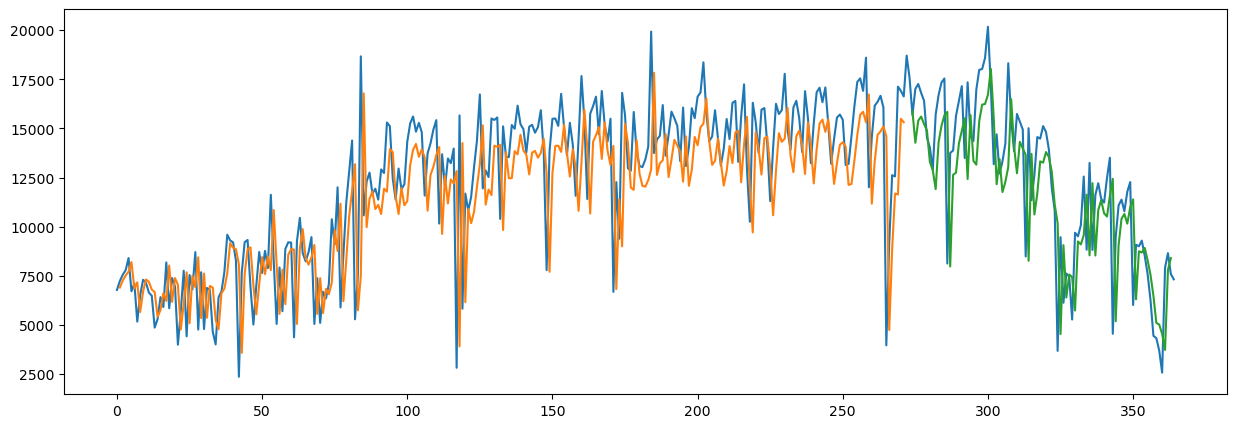

In [472]:
# plot baseline and predictions
plt.figure(figsize=(15, 5))

plt.plot(scaler.inverse_transform(np_trips))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()